# Spatial subsetting with a NetCDF file


This notebook demonstrates usage of the `spatial_subset_netcdf` WPS process, with additional visualisation of the output.

## Prerequisites
Some packages are required to be installed in your environment prior to running this notebook.
Run the below system command to install these packages.

In [1]:
# Note: Version pinning required to work around https://github.com/matplotlib/basemap/issues/435
# <This issue should be resolved upon release of matplotlib==3.0.2>

In [ ]:
!conda install -f -y \
    netCDF4 \
    basemap=1.2.0 \
    matplotlib=3.0.0

## Importing packages

In [3]:
import owslib.wps
import urllib.request

from netCDF4 import Dataset as NetCDFDataset
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

## Accessing the WPS server
The URL of the server is the only required piece of information to initialise the WPS object.
This object will be used later to communicate with the WPS server.

In [4]:
wps_server_url = "https://wps.test.ecocloud.org.au/wps"
wps = owslib.wps.WebProcessingService(wps_server_url)

## Finding out about the `spatial_subset_netcdf` WPS process
As WPS processes are able to describe themselves, you can run the following to find out what inputs and outputs it has. This is completely optional - you can skip this if you already have advance knowledge of the process.

In [5]:
from IPython.display import display, HTML
import pandas as pd

process_name = "spatial_subset_netcdf"
description = wps.describeprocess(process_name)

# Describes the process
process_info = [
    ["Identifier", description.identifier],
    ["Title", description.title],
    ["Abstract", description.abstract],
]

display(HTML("<h3>Process information</h3>"))
display(pd.DataFrame(process_info, columns=["", ""]))

# Describes inputs to the process
process_inputs = []
for data_input in description.dataInputs:
    process_inputs.append([data_input.identifier, data_input.title])

display(HTML("<h3>Process inputs</h3>"))
display(pd.DataFrame(process_inputs, columns=["Parameter", "Title"]))


# Describes outputs of the process
process_outputs = []
for process_output in description.processOutputs:
    process_outputs.append([process_output.identifier, process_output.title])

display(HTML("<h3>Process outputs</h3>"))
display(pd.DataFrame(process_outputs, columns=["Parameter", "Title"]))

,,
0,Identifier,spatial_subset_netcdf
1,Title,NetCDF data spatial subset
2,Abstract,Subsets a given NetCDF dataset with given spat...


,Parameter,Title
0,dataset,NetCDF Dataset
1,shapefile,.zip file representing ESRI Shapefile of geome...
2,variable,Variable to subset


,Parameter,Title
0,output,Metadata


## Constructing the WPS request
The input parameters of the request to the `spatial_subset_netcdf` process are bundled in a list of tuples as below.

The example here uses rainfall data hosted by NCI, with subsetting to occur over the `lwe_thickness_of_precipitation_amount` data variable clipped to a shapefile of Queensland hosted by ALA.

You may notice `ComplexDataInput()` being used for the `dataset` and `shapefile` inputs - the WPS process expects "complex" data inputs for these, and these are generally found for references to data or binary files.

In [6]:
dataset_url = "http://dapds00.nci.org.au/thredds/fileServer/rr9/ANUClimate/ANUClimate_v1-0_rainfall_monthly-mean_0-01deg_1976-2005/00000000/ANUClimate_v1-0_rainfall_monthly-mean_0-01deg_1976-2005_00000000_09.nc"
dataset_variable = "lwe_thickness_of_precipitation_amount"
shapefile_url = "http://spatial.ala.org.au/ws/shape/shp/3742606"

inputs = [
    ("dataset", owslib.wps.ComplexDataInput(dataset_url)),
    ("variable", dataset_variable),
    ("shapefile", owslib.wps.ComplexDataInput(shapefile_url)),
]

## Executing the WPS request
Execution involves simply handing off the input to the WPS server and telling it which process to run it under.

We also tell the `execute()` method that the output we expect is named `output` and the execution mode is asynchronous (`ASYNC`) which requires us to check back with the server to find out when the request has been completed.

This check is done in the next cell - a loop runs until the request is complete, with a check occurring every 5 seconds.

In [7]:
process_name = "spatial_subset_netcdf"
request = wps.execute(process_name, inputs, output="output", mode=owslib.wps.ASYNC)

In [8]:
# Loop checks status every 5 seconds
while not request.isComplete():
    request.checkStatus(sleepSecs=5)

# Once we are done...
print("Done")

Done


## Retrieving the output
Once the WPS server is done, the URL to the output is provided and can be used to download the output NetCDF file.

In [9]:
output_url = request.processOutputs[0].reference
file_path, _ = urllib.request.urlretrieve(output_url)

## Reading the output
As the output is a NetCDF file, we pass it into `NetCDFDataset()` and read out the data from variables within the dataset (here, the latitude, longitude and precipitation defined by `dataset_variable` from before.)

In [14]:
nc = NetCDFDataset(file_path)

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
dataset_variable_data = nc.variables[dataset_variable][:][0,:,:]

## Visualising the output
For the example data here, we can present it on a map of Australia as shown below.

In [15]:
# Create map around Australia
map = Basemap(projection='merc',llcrnrlat=-45,urcrnrlat=-9,llcrnrlon=111,urcrnrlon=155,resolution='l')

In [16]:
# Map longitude and latitude into plot domain
lons,lats = np.meshgrid(lon,lat)
x,y = map(lons,lats)

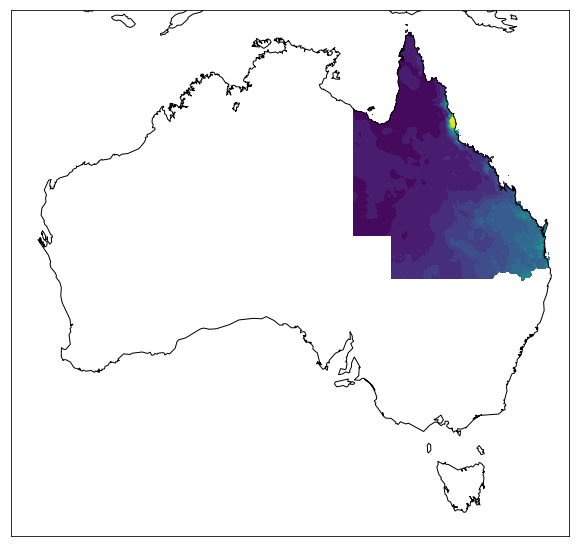

In [17]:
# Plot
plt.figure(figsize=(10,10))
map.drawcoastlines()
map.drawcountries()
map.contourf(x,y,dataset_variable_data,levels=np.arange(0,100,5))
plt.show()